In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
import tensorflow.random as tfr


2022-02-13 23:13:42.800873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 23:13:42.800901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# parallelization modules 
import os
import time
from multiprocessing import Process, Queue, SimpleQueue

In [3]:
def single_lik(mu,sigma2):
    sigma= np.sqrt(sigma2)
    return tfd.Normal(mu,sigma)

In [4]:
def prior_mu():
    return tfd.Normal(mu0,sigma0)

In [5]:
def prior_sigma2():
    return tfd.InverseGamma(c,d)

In [6]:
def proposal_mu(mu):
    return tfd.Normal(mu,1)

In [7]:
def proposal_sigma(sigma):
    return tfd.LogNormal(sigma,0.1)

In [8]:
def my_kernel(u):
    return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [9]:
def K_h(u,h):
    return my_kernel(u/h)/h

In [10]:
def S1(y):
    s_1 = np.mean(y)
    s_2 = np.var(y)
    return [s_1,s_2]

In [11]:
##MAXIMAL COUPLING FOR DATASET GENERATION
#riceve sigma^2 perché c'è la radice in single_lik()

def maximal_coupling2(mu_x,sigma_x,mu_y,sigma_y):

    proposed_x = single_lik(mu_x,sigma_x).sample()
    pX =  single_lik(mu_x,sigma_x).prob(proposed_x)
    w = tfd.Uniform(0,1).sample()*pX
    qX = single_lik(mu_y,sigma_y).prob(proposed_x)
    if w < qX:
        x_new = proposed_x
        y_new = proposed_x
    else:
        t = True
        while t == True:
            proposed_y = single_lik(mu_y,sigma_y).sample()
            qY =  single_lik(mu_y,sigma_y).prob(proposed_y) 
            w =  tfd.Uniform(0,1).sample()*qY
            pY = single_lik(mu_x,sigma_x).prob(proposed_y)
            if w > pY:
                t = False

        x_new = proposed_x
        y_new = proposed_y  
          
    return x_new,y_new

In [12]:
def double_coupling(x,y):
   
    current_x = x
    current_y = y  
    proposed_x = current_x + np.random.multivariate_normal(np.zeros(2),0.1*np.identity(2))
    pX = sstat.multivariate_normal.pdf(proposed_x,current_x,np.identity(2))
    w = tfd.Uniform(0,1).sample()*pX
    qX = sstat.multivariate_normal.pdf(proposed_x,current_y,np.identity(2))
    if w < qX:
        x_new = proposed_x
        y_new = proposed_x
    else:
        t = True
        while t == True:
            proposed_y = current_y + np.random.multivariate_normal(np.zeros(2),0.1*np.identity(2))
            qY =  sstat.multivariate_normal.pdf(proposed_y,current_y,1) 
            w =  tfd.Uniform(0,1).sample()*qY
            pY = sstat.multivariate_normal.pdf(proposed_y,current_x,1)
            if w > pY :
                t = False

        x_new = proposed_x
        y_new = proposed_y

    return x_new, y_new

In [13]:
def abc_algo (N, S, y_obs, h):
    acc_x = 0
    acc_y = 0
    s_obs = S(y_obs)
    theta_mu_x = []
    theta_sigma_x = []
    theta_mu_y = []
    theta_sigma_y = []
    datax_current = []
    datay_current = [] 
    theta_sigma_x0 = prior_sigma2().sample()
    theta_sigma_y0 = prior_sigma2().sample()
    theta_mu_x0 = prior_mu().sample()
    theta_mu_y0 = prior_mu().sample()

    for j in range (100):
      #manda sigma^2 che poi c'è la radice nella funzione
                  newdata_x,newdata_y = maximal_coupling2(theta_mu_x0,theta_sigma_x0,theta_mu_y0,theta_sigma_y0)
                  datax_current.append(newdata_x)
                  datay_current.append(newdata_y)
    sx_0 = S(datax_current)
    sy_0 = S(datay_current)

    while K_h(np.linalg.norm(np.array(sx_0)-np.array(s_obs)),h)<=0:
        theta_sigma_x0 = prior_sigma2().sample()
        theta_mu_x0 = prior_mu().sample()
        datax_0 = single_lik(theta_mu_x0,theta_sigma_x0).sample(100) 
        sx_0 = S(datax_0)


    while K_h(np.linalg.norm(np.array(sy_0)-np.array(s_obs)),h)<=0:
        theta_sigma_y0 =prior_sigma2().sample()
        theta_mu_y0 = prior_mu().sample()
        datay_0 = single_lik(theta_mu_y0,theta_sigma_y0).sample(100) 
        sy_0 = S(datay_0)
    
    theta_mu_x.append(theta_mu_x0)
    theta_sigma_x.append(theta_sigma_x0)
    theta_mu_y.append(theta_mu_y0)
    theta_sigma_y.append(theta_sigma_y0)
   
    theta_muold_x = theta_mu_x0
    theta_sigmaold_x = theta_sigma_x0
    theta_muold_y = theta_mu_y0
    theta_sigmaold_y = theta_sigma_y0
    sx_old = sx_0
    sy_old = sy_0
    

    for i in range(N):
        theta_x = np.array([theta_muold_x,np.log(theta_sigmaold_x) ])
        theta_y = np.array([theta_muold_y,np.log(theta_sigmaold_y) ])
        theta_current_x,theta_current_y = double_coupling(theta_x,theta_y)

        datax_current = []
        datay_current = [] 

        for j in range (100):
            [newdata_x,newdata_y] = maximal_coupling2(theta_current_x[0],np.exp(theta_current_x[1]),theta_current_y[0],np.exp(theta_current_y[1]))
            datax_current.append(newdata_x)
            datay_current.append(newdata_y)

        sx_current = S(datax_current)
        sy_current = S(datay_current) 
               
        theta_mucurrent_x=theta_current_x[0]
        theta_sigmacurrent_x =np.exp(theta_current_x[1])
        theta_mucurrent_y=theta_current_y[0]
        theta_sigmacurrent_y=np.exp(theta_current_y[1])

        xprob = min([1.,(K_h(np.linalg.norm(np.array(sx_current) - np.array(s_obs)),h)*prior_sigma2().prob(theta_sigmacurrent_x**2)*prior_mu().prob(theta_mucurrent_x))/(
             K_h(np.linalg.norm(np.array(sx_old)-np.array(s_obs)),h)*(prior_sigma2().prob(theta_sigmaold_x**2)*prior_mu().prob(theta_muold_x)))])
        yprob = min([1.,(K_h(np.linalg.norm(np.array(sy_current) - np.array(s_obs)),h)*prior_sigma2().prob(theta_sigmacurrent_y**2)*prior_mu().prob(theta_mucurrent_y))/(
             K_h(np.linalg.norm(np.array(sy_old)-np.array(s_obs)),h)*(prior_sigma2().prob(theta_sigmaold_y**2)*prior_mu().prob(theta_muold_y)))])
     
        u = tfd.Uniform(0,1).sample()

        if u < xprob:
            theta_mui_x = theta_mucurrent_x
            theta_sigmai_x = theta_sigmacurrent_x
            s_ix = sx_current
            acc_x +=1
        else: 
            theta_mui_x = theta_muold_x
            theta_sigmai_x = theta_sigmaold_x
            s_ix = sx_old

        if u < yprob:
            theta_mui_y = theta_mucurrent_y
            theta_sigmai_y = theta_sigmacurrent_y
            s_iy = sy_current
            acc_y +=1
        else: 
            theta_mui_y = theta_muold_y
            theta_sigmai_y = theta_sigmaold_y
            s_iy = sy_old
              

        theta_muold_x = theta_mui_x
        theta_sigmaold_x = theta_sigmai_x
        sx_old = s_ix

        theta_muold_y = theta_mui_y
        theta_sigmaold_y = theta_sigmai_y
        sy_old = s_iy
        
        theta_mu_x.append(theta_mui_x)
        theta_sigma_x.append(theta_sigmai_x)
        theta_mu_y.append(theta_mui_y)
        theta_sigma_y.append(theta_sigmai_y)
        
        
    return  theta_mu_x, theta_mu_y, theta_sigma_x, theta_sigma_y, acc_x , acc_y

In [14]:
##VARIABILI:
c = 1
d = 1
mu0 = 8.
sigma0 = np.sqrt(4.)
k = 5
n = 100
mu_obs = 10
sigma_obs = np.sqrt(3.)
y_obs = tfp.distributions.Normal(mu_obs, sigma_obs).sample(n)

test_function_h = lambda x: x

In [15]:
def time_averaged_estimator(red_chain, blue_chain, iterations, burnout, meeting_time):
    #this function calculates only the formula at point 3
    
    #first addend
    first_sum = 0
    for i in range(burnout, iterations):
        first_sum += test_function_h(red_chain[i])
    
    #second addend
    second_sum = 0
    if meeting_time-1 > burnout + 1:
        for i in range(burnout + 1, meeting_time):
            # calculing the coefficient, and the min
            coef = (1-burnout)(iterations - burnout + 1)
            if coef > 1:
                coef = 1
            second_sum += coef * (test_function_h(red_chain[i])- test_function_h(blue_chain[i]))
            
    return (1/(iterations - burnout + 1))*first_sum + second_sum

In [16]:
def parallelized_operations(
    iterations, burnout, chains_matching_tolerance, 
    q_chain_mu,
    q_chain_sigma,
    q_meeting_time, 
    q_time_averaged_estimator_mu,
    q_time_averaged_estimator_sigma,
    q_acc_x,
    q_acc_y):
    
    # setting a random seed - otherwise multiprocessing has the same seed and so they end up in the same chains!
    np.random.seed(int(os.getpid() * time.time()) % 123456789 )
    tfr.set_seed(int(os.getpid() * time.time()) % 123456789 )
    
    #running metropolis hastings and obtaining two chains
    provamux, provamuy, provasigmax, provasigmay, acc_x , acc_y = abc_algo (iterations, S1, y_obs, 0.3)   
    #(red_chain, blue_chain) = metropolis_hastings(iterations)
    
    
    #get the dimensionality from one of the chains
    #dimensionality = red_chain.shape[0]

    #finding the meeting time
    meeting_time = iterations + 2
    for i in range(0, iterations-2):
        if (abs(provamux[i]-provamuy[i]).all() < chains_matching_tolerance) & \
            (abs(provamux[i+1]-provamuy[i+1]).all() < chains_matching_tolerance) & \
            (abs(provamux[i+2]-provamuy[i+2]).all() < chains_matching_tolerance) & \
            (abs(provasigmax[i]-provasigmay[i]).all() < chains_matching_tolerance) & \
            (abs(provasigmax[i+1]-provasigmay[i+1]).all() < chains_matching_tolerance) & \
            (abs(provasigmax[i+2]-provasigmay[i+2]).all() < chains_matching_tolerance) :
            meeting_time = i
            break
    
    #checking if the chains met
    if meeting_time == iterations+2:
        print('Matching did not occurred!')
        print(meeting_time)
        return
    
    #checking if the chains met before burnout
    if meeting_time >= burnout:
        print('Meeting time occurs after burnout iterations!')
        print(meeting_time)
        return
    
    time_averaged_estimation_mu = time_averaged_estimator(
            provamux, 
            provamuy, 
            iterations, burnout, meeting_time
        )
    
    time_averaged_estimation_sigma = time_averaged_estimator(
        provasigmax, 
        provasigmay, 
        iterations, burnout, meeting_time
    )
    
    #print('hello after time averaged estimation ' 
    #      + str(os.getpid())
    #      + ' ' + str(time_averaged_estimation_mu)
    #      + ' ' + str(time_averaged_estimation_sigma)
    #     )
    
    #print(red_chain)
    q_chain_mu.put( provamux )
    q_chain_sigma.put( provasigmax )
    q_meeting_time.put( meeting_time )
    q_time_averaged_estimator_mu.put( time_averaged_estimation_mu )
    q_time_averaged_estimator_sigma.put( time_averaged_estimation_sigma )
    q_acc_x.put( acc_x )
    q_acc_y.put( acc_y )
    
    return


In [17]:
# this returns the number of available processors
num_processes = os.cpu_count()
num_processes

# this set the number of iteration, it should be a multiple of the number of available processors
num_batches_set = 4 #16*1 #set this
num_batches = num_batches_set

# this initialize a shared memory between processors
# note of Queue(maxsize = 0)
q_chain_mu = SimpleQueue()
q_chain_sigma = SimpleQueue()
q_meeting_time = SimpleQueue()
q_time_averaged_estimator_mu = SimpleQueue()
q_time_averaged_estimator_sigma = SimpleQueue()
q_acc_x = SimpleQueue()
q_acc_y = SimpleQueue()

In [18]:

samplings_mu = np.empty(0)
samplings_sigma = np.empty(0)
time_averaged_estimation_mu_sum = 0
time_averaged_estimation_sigma_sum = 0
meeting_times = np.empty(0)
correct_chains = 0

acc_x = np.empty(0)
acc_y = np.empty(0)

iterations = 1000
burnout = 100
# coupling tolerance
chains_matching_tolerance = 1e-3

while num_batches > 0:
    
    print("There are " + str(num_batches) + " left")
    
    if num_batches >= num_processes:
        current_number_processes = num_processes
    else:
        current_number_processes = num_batches
    
    processes = []
    for batch in range(current_number_processes):
        p = Process(
            target = parallelized_operations, 
            args = (iterations, burnout, 
                    chains_matching_tolerance, 
                    q_chain_mu, 
                    q_chain_sigma,
                    q_meeting_time, 
                    q_time_averaged_estimator_mu,
                    q_time_averaged_estimator_sigma,
                    q_acc_x,
                    q_acc_y)
        )
        processes.append(p)

    num_batches -= current_number_processes
    
    # Starting the processes in a batch
    for p in processes:
        p.start()
        time.sleep(0.1)

    # This assures that each process in the batch is complete
    for p in processes:
        p.join()

    print('Hello since all processes are ended')

    while not q_chain_mu.empty():
        chain_mu = np.array(q_chain_mu.get())
        samplings_mu = np.append(
            samplings_mu,
            chain_mu[burnout :],
            axis = 0
        )
        
        chain_sigma = np.array(q_chain_sigma.get())
        samplings_sigma = np.append(
            samplings_sigma,
            chain_sigma[burnout :],
            axis = 0
        )

        meeting_time = q_meeting_time.get()
        
        time_averaged_estimation_mu = q_time_averaged_estimator_mu.get()
        time_averaged_estimation_sigma = q_time_averaged_estimator_sigma.get()
        
        if meeting_time <= burnout: #this to avoid a biased time averaged estimator
            time_averaged_estimation_mu_sum += time_averaged_estimation_mu
            time_averaged_estimation_sigma_sum += time_averaged_estimation_sigma
            correct_chains += 1
        
        meeting_times = np.append(
            meeting_times,
            meeting_time
        )
        
        acc_x = np.append(
            acc_x,
            q_acc_x.get()
        )
        
        acc_y = np.append(
            acc_y,
            q_acc_y.get()
        )
    
del q_chain_mu, q_chain_sigma,  q_meeting_time, q_time_averaged_estimator_mu, q_time_averaged_estimator_sigma, q_acc_x, q_acc_y
print('All processes are complete!')

There are 4 left
Hello since all processes are ended
All processes are complete!


In [19]:
print(meeting_times)
print(len(meeting_times))
print(num_batches_set-len(meeting_times))

[ 2.  6. 32. 24.]
4
0


In [20]:
samplings_mu.size

3604

In [21]:
samplings_sigma.size

3604

In [22]:
time_averaged_estimation_mu_mean = time_averaged_estimation_mu_sum/correct_chains
time_averaged_estimation_mu_mean

9.780552060387604

In [23]:
time_averaged_estimation_sigma_mean = time_averaged_estimation_sigma_sum/correct_chains
time_averaged_estimation_sigma_mean

2.569704987917513

In [24]:
acc_x

array([225., 235., 238., 238.])

In [25]:
acc_y

array([226., 235., 232., 242.])

In [26]:
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12,4)

#### Sampling plot and Histogram for all variables

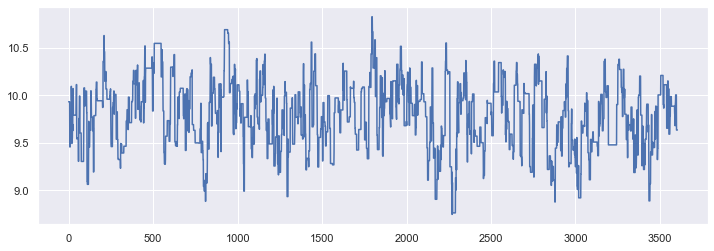

In [27]:
plt.plot(samplings_mu)
plt.savefig('doublecoupling_sampling_mu.png')

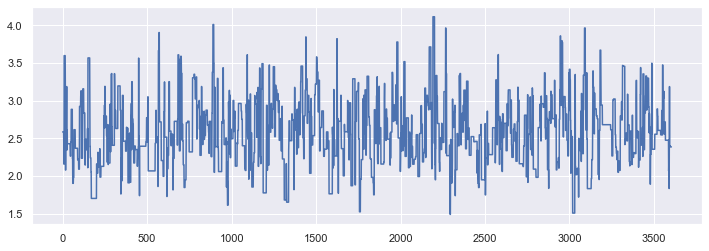

In [28]:
plt.plot(samplings_sigma)
plt.savefig('doublecoupling_sampling_sigma.png')

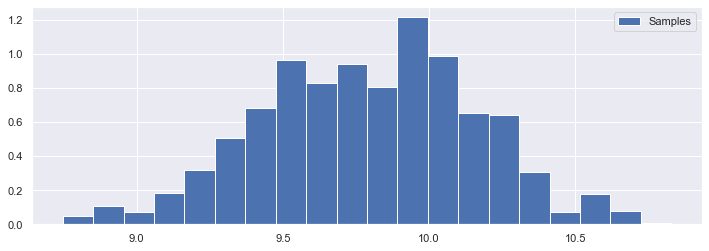

In [29]:
plt.hist(samplings_mu, bins = 20, density = True, label = 'Samples')
plt.legend()
plt.savefig('doublecoupling_mu_histogram.png')

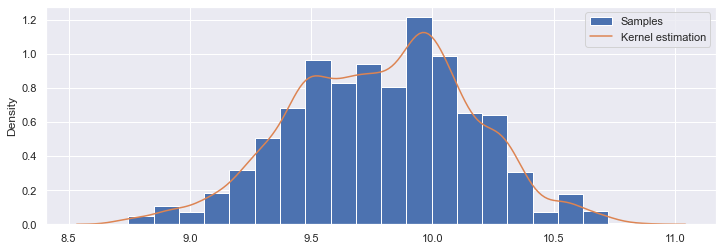

In [30]:
plt.hist(samplings_mu, bins = 20, density = True, label = 'Samples')
sns.kdeplot(data = samplings_mu, label = 'Kernel estimation')
plt.legend()
plt.savefig('doublecoupling_mu_histogram_kernel.png')

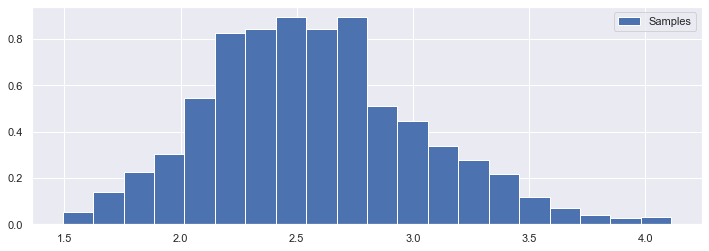

In [31]:
plt.hist(samplings_sigma, bins = 20, density = True, label = 'Samples')
plt.legend()
plt.savefig('doublecoupling_sigma_histogram.png')

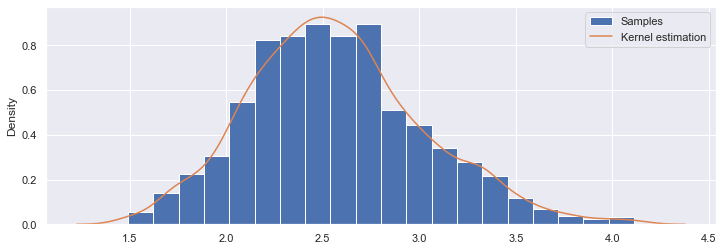

In [32]:
plt.hist(samplings_sigma, bins = 20, density = True, label = 'Samples')
sns.kdeplot(data = samplings_sigma, label = 'Kernel estimation')
plt.legend()
plt.savefig('doublecoupling_sigma_histogram_kernel.png')

In [ ]:
(mux, muy, sigmax, sigmay, a_x , a_y) = abc_algo (1000, S1, y_obs, 0.3)   

In [ ]:
plt.plot(mux)
plt.plot(muy)
plt.savefig('doublecoupling_mu_chain_meeting.png')

In [ ]:
plt.plot(sigmax)
plt.plot(sigmay)
plt.savefig('doublecoupling_sigma_chain_meeting.png')